# Recomendador de peliculas

## Carga de librerias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Importar datos

In [2]:
df = pd.read_csv("dfcl.csv")
data = pd.read_csv("datacl.csv")
users = pd.read_csv("userscl.csv")
movies = pd.read_csv("moviescl.csv")
ratings = pd.read_csv("ratingscl.csv")

In [3]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0' in data.columns:
    data = data.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0' in users.columns:
    users = users.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0' in movies.columns:
    movies = movies.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0' in ratings.columns:
    ratings = ratings.drop(columns=['Unnamed: 0'])

In [4]:
df.head()

,user_id,movie_id,rating,unix_timestamp,title
0,196,242,3.0,881250949,Kolya (1996)
1,186,302,3.0,891717742,L.A. Confidential (1997)
2,22,377,1.0,878887116,Heavyweights (1994)
3,244,51,2.0,880606923,Legends of the Fall (1994)
4,166,346,1.0,886397596,Jackie Brown (1997)


In [5]:
data.head()

,occupation,age
0,retired,63.071429
1,doctor,43.571429
2,educator,42.010526
3,healthcare,41.562500
4,librarian,40.000000


In [6]:
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [7]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995.0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1995.0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995.0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995.0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995.0


In [8]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


# Recomendadores por popularidad

In [9]:
titles = movies[['title', 'movie_id']]
df = pd.merge(ratings, titles, on='movie_id')
df.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: rating, dtype: int64

In [10]:
ratings_df = pd.DataFrame(df.groupby('movie_id')['rating'].count())
ratings_df

,rating
movie_id,
1,452
2,131
3,90
4,209
5,86
...,...
1678,1
1679,1
1680,1


In [11]:
# Renombramos el campo
ratings_df.rename(columns={'rating': 'num_rating'}, inplace=True)
# Calculamos el promedio de las puntuaciones
ratings_df['mean_ratings'] = pd.DataFrame(df.groupby('movie_id')['rating'].mean())
# Y la puntuación final como el producto entre ambas
ratings_df['score'] = ratings_df['mean_ratings'] * ratings_df['num_rating']
ratings_df.sort_values(by='score', ascending=False).head(10)

,num_rating,mean_ratings,score
movie_id,,,
50,583,4.358491,2541.0
100,508,4.155512,2111.0
181,507,4.007890,2032.0
258,509,3.803536,1936.0
174,420,4.252381,1786.0
127,413,4.283293,1769.0
286,481,3.656965,1759.0
1,452,3.878319,1753.0
98,390,4.289744,1673.0


Con esta información podremos en base a la popularidad de las películas no vistas por el usuario, realizar una primera recomendación.

In [12]:
def popularity_based_recommender(user_id:int):
  """
  Devolveremos las diez películas más vistas y mejor valoradas que no haya visto el usuario indicado por user_id
  """
  # Obtenemos 100 candidatos a ser recomendados (por disponer de una muestra de generación)
  top_rated = ratings_df.sort_values(by='score', ascending=False).head(100)

  # Obtenemos las películas ya vistas por el usuario
  already_seen = ratings[ratings["user_id"] == user_id]["movie_id"]

  # Nos quedamos con aquellas no vistas del conjunto inicial
  not_seen = top_rated.merge(already_seen.drop_duplicates(), on=['movie_id','movie_id'], how='left', indicator=True)
  return_df = not_seen[not_seen['_merge'] == 'left_only']["movie_id"]

  # Añadimos el título y ofrecemos diez candidatas
  return pd.merge(return_df, titles, on='movie_id')["title"].head(10)

In [13]:
popularity_based_recommender(1)

0               English Patient, The (1996)
1                             Scream (1996)
2                      Air Force One (1997)
3                          Liar Liar (1997)
4                            Titanic (1997)
5                   Schindler's List (1993)
6                  L.A. Confidential (1997)
7         E.T. the Extra-Terrestrial (1982)
8                Mission: Impossible (1996)
9    One Flew Over the Cuckoo's Nest (1975)
Name: title, dtype: object

In [14]:
popularity_based_recommender(196)

0                    Star Wars (1977)
1                        Fargo (1996)
2           Return of the Jedi (1983)
3                      Contact (1997)
4      Raiders of the Lost Ark (1981)
5               Godfather, The (1972)
6                    Toy Story (1995)
7    Silence of the Lambs, The (1991)
8                       Scream (1996)
9                 Pulp Fiction (1994)
Name: title, dtype: object

Esta modalidad de recomendación es quizás de las más sencillas y en cualquier caso, unicamente diponiendo de la información asociada a los ítems vistos por los usuarios puede contarse con una recomendación sobre los títulos más populares. Dentro del caracter general de estos modos de recomendación estas recomendaciones pueden ser segregadas por popularidad entre adolescentes o algún perfil laboral en concreto para lo cual necesitaremos algo más de información asociada al usuario en cuestión que valoramos.

In [15]:
def favorite_movies(user_id:int, num=10):
  """
  Devolveremos los 10 títulos mejor valorados por un usuario
  """
  # Obtenemos las películas ya vistas por el usuario
  rated = ratings[ratings["user_id"] == user_id]
  
  # Las películas valoradas por este
  rated_info = pd.merge(rated, titles, on='movie_id')[["movie_id","title","rating"]]
  return rated_info.sort_values(by='rating', ascending=False).head(num)

In [16]:
favorite_movies(196)

,movie_id,title,rating
27,285,Secrets & Lies (1996),5.0
14,692,"American President, The (1995)",5.0
4,655,Stand by Me (1986),5.0
5,67,Ace Ventura: Pet Detective (1994),5.0
31,153,"Fish Called Wanda, A (1988)",5.0
8,663,Being There (1979),5.0
12,286,"English Patient, The (1996)",5.0
15,8,Babe (1995),5.0
29,1007,Waiting for Guffman (1996),4.0
30,411,"Nutty Professor, The (1996)",4.0


In [17]:
favorite_movies(1)

,movie_id,title,rating
136,170,Cinema Paradiso (1988),5.0
67,175,Brazil (1985),5.0
182,119,Maya Lin: A Strong Clear Vision (1994),5.0
186,181,Return of the Jedi (1983),5.0
191,109,Mystery Science Theater 3000: The Movie (1996),5.0
77,44,Dolores Claiborne (1994),5.0
75,14,"Postino, Il (1994)",5.0
74,12,"Usual Suspects, The (1995)",5.0
194,223,Sling Blade (1996),5.0
72,108,Kids in the Hall: Brain Candy (1996),5.0


Conociendo los gustos de los usuarios sería interesante poder recomendar películas _similares_ de forma que maximicemos la experiencia de nuestro usuario. Podemos así ofrecerle contenido afin a sus gustos registrados. Y aquí es donde entran en juego las méticas de similitud.

Las métricas de similitud pretenden establecer un valor numérico de cómo de similares son dos elementos. El rango variará en base a la métrica en cuestión de modo que os presentamos algunas de las más comunes.

## Relacion de peliculas

In [18]:
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = ['movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols

In [19]:
data = movies[['title']+genre_cols].set_index('title')
cosine_sim = cosine_similarity(data)

Con esto hemos construido un comparador basado en los géneros de las películas, de modo que si indicamos que nos gusa un Drama nos ofrecerá títulos simialres (Dramas). Evidentemente, cuanta más información dispongamos del contenido más precisas serán estas métricas.

In [20]:
# Convertimos nuestra matriz en un DataFrame con índices y columnas indicando la relación entre películas
sim_matrix = pd.DataFrame(cosine_sim)
sim_matrix.columns = movies['movie_id'].values
sim_matrix.index += 1
sim_matrix

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
1,1.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.57735,0.000000
2,0.000000,1.000000,0.577350,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.816497,0.000000,0.000000,0.000000,0.000000,0.000000,0.408248,0.000000,0.00000,0.000000
3,0.000000,0.577350,1.000000,0.000000,0.577350,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.00000,0.000000
4,0.333333,0.333333,0.000000,1.000000,0.333333,0.577350,0.408248,0.666667,0.577350,0.408248,...,0.408248,0.577350,0.577350,0.577350,0.577350,0.577350,0.000000,0.408248,0.57735,0.577350
5,0.000000,0.333333,0.577350,0.333333,1.000000,0.577350,0.408248,0.333333,0.577350,0.408248,...,0.408248,0.577350,0.577350,0.577350,0.577350,0.577350,0.408248,0.408248,0.00000,0.577350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,0.000000,0.000000,0.000000,0.577350,0.577350,1.000000,0.707107,0.577350,1.000000,0.707107,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.707107,0.00000,1.000000
1679,0.000000,0.408248,0.707107,0.000000,0.408248,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.00000,0.000000
1680,0.000000,0.000000,0.000000,0.408248,0.408248,0.707107,0.500000,0.408248,0.707107,0.500000,...,0.000000,0.707107,0.707107,0.707107,0.707107,0.707107,0.500000,1.000000,0.00000,0.707107
1681,0.577350,0.000000,0.000000,0.577350,0.000000,0.000000,0.000000,0.577350,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000


In [21]:
def find_similar(movie_id):
  # Obtenemos las métricas para las peliculas
  m_list = sim_matrix.loc[movie_id].tolist()
  # Filtramos por aquellas simialres
  similar_movies = [i+1 for i,x in enumerate(m_list) if x >= 0.99]
  # Devolvemos los titulos
  return movies[movies["movie_id"].isin(similar_movies)][["title"] + genre_cols]

In [22]:
find_similar(1)

,title,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,Toy Story (1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
421,Aladdin and the King of Thieves (1996),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
find_similar(7)

,title,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
6,Twelve Monkeys (1995),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
257,Contact (1997),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
428,"Day the Earth Stood Still, The (1951)",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1005,Until the End of the World (Bis ans Ende der W...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


Al igual que la similitud de coseno, disponemos de otras métricas como la *distancia de Jaccard* o la *correlación de Pearson* que aportan esta misma visión sobre la proximidad entre distintos items en base a sus campos informados. Podemos completar los datos disponibles con información sobre los actores de las películas, lenguajes en las que se encuentran disponibles o directores de forma que cuanta más información contextual tengamos sobre los items, más precisas serán las métricas de similitud. Existen escenarios donde una métricas ofrecerán resultados más robustos que el resto, debido a la codificación de los campos, uso de valores discretos o conínuos, etc. Será nuestra labor entender cual es la mejor métrica en cada caso.

Estas métrica de similitud nos permiten realizar recomendaciones mucho más elavoradas que permitan adecuar las recomendaciones a los gustos del usuario basados en contenidos similares.

# Recomendadores basadas en contenido

In [24]:
def content_based_recommender(user_id, num=10):
   """
   Devolvemos el numero de películas indicadas a recomendar que el usuario no haya visto y sean 
   similares a las películas vistas y puntuadas con un rating alto por el mismo usuario.
   """
   # Películas mejor puntuadas por el usuario
   fav_movies = favorite_movies(user_id, 10)

   # Películas no vistas por el usuario (candidatas)
   already_seen = ratings[ratings["user_id"] == user_id]["movie_id"]
   not_seen = movies.merge(already_seen.drop_duplicates(), on=['movie_id','movie_id'], how='left', indicator=True)
   not_seen_id = not_seen[not_seen['_merge'] == 'left_only']["movie_id"]

   # Para cada película buscamos en su matriz de similitud lo títulos más similares, 
   # su máxima similitud con las películas valoradas y nos quedamos con las num primeras
   value_matrix = sim_matrix[fav_movies["movie_id"].to_list()]
   movies_to_recommend = value_matrix.loc[not_seen_id.to_list()]
   movies_to_recommend['average'] = movies_to_recommend.mean(numeric_only=True, axis=1)
   chosen_movies = movies_to_recommend['average'].sort_values(ascending=False).head(num).reset_index()["index"].to_list()

   return titles[titles["movie_id"].isin(chosen_movies)]

In [25]:
favorite_movies(196)

,movie_id,title,rating
27,285,Secrets & Lies (1996),5.0
14,692,"American President, The (1995)",5.0
4,655,Stand by Me (1986),5.0
5,67,Ace Ventura: Pet Detective (1994),5.0
31,153,"Fish Called Wanda, A (1988)",5.0
8,663,Being There (1979),5.0
12,286,"English Patient, The (1996)",5.0
15,8,Babe (1995),5.0
29,1007,Waiting for Guffman (1996),4.0
30,411,"Nutty Professor, The (1996)",4.0


In [26]:
content_based_recommender(196)

,title,movie_id
344,Deconstructing Harry (1997),345
346,Wag the Dog (1997),347
736,Sirens (1994),737
903,Ma vie en rose (My Life in Pink) (1997),904
1102,Trust (1990),1103
1338,Stefano Quantestorie (1993),1339
1556,Yankee Zulu (1994),1557
1568,"Vie est belle, La (Life is Rosey) (1987)",1569
1587,Salut cousin! (1996),1588
1632,Á köldum klaka (Cold Fever) (1994),1633


In [27]:
favorite_movies(1)

,movie_id,title,rating
136,170,Cinema Paradiso (1988),5.0
67,175,Brazil (1985),5.0
182,119,Maya Lin: A Strong Clear Vision (1994),5.0
186,181,Return of the Jedi (1983),5.0
191,109,Mystery Science Theater 3000: The Movie (1996),5.0
77,44,Dolores Claiborne (1994),5.0
75,14,"Postino, Il (1994)",5.0
74,12,"Usual Suspects, The (1995)",5.0
194,223,Sling Blade (1996),5.0
72,108,Kids in the Hall: Brain Candy (1996),5.0


In [28]:
content_based_recommender(1)

,title,movie_id
336,"House of Yes, The (1997)",337
511,Wings of Desire (1987),512
516,Manhattan (1979),517
691,"American President, The (1995)",692
730,"Corrina, Corrina (1994)",731
774,Something to Talk About (1995),775
935,Brassed Off (1996),936
1099,What Happened Was... (1994),1100
1114,Twelfth Night (1996),1115
1423,I Like It Like That (1994),1424


## Redes neuronales

In [29]:
# Copiamos nuestro conjunto de datos de puntuaciones
df = ratings

# Codificamos los identificadores de usuarios
user_ids = df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
num_users = len(ratings["user_id"].unique())

# Codificamos los identificadores de los items
movie_ids = df["movie_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
num_movies = len(ratings["movie_id"].unique())

# Y los incorporamos al conjunto de datos
df["user"] = df["user_id"].map(user2user_encoded)
df["movie"] = df["movie_id"].map(movie2movie_encoded)

In [30]:
# Rango de valores para los ratings
min_rating = 1.0
max_rating = 5.0

# Datos de entrada para nuestra red
x = df[["user", "movie"]].values

# Normalizamoz los ratings entre 0 y 1
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Realizamos la separación entre entrenamiento y validación
idx = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:idx],
    x[idx:],
    y[:idx],
    y[idx:],
)

In [31]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        # Definir las capas de embeddings para usuarios y películas
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        x = dot_user_movie + user_bias + movie_bias
        return tf.nn.sigmoid(x)

    def get_config(self):
        config = super(RecommenderNet, self).get_config()
        config.update({
            "num_users": self.num_users,
            "num_movies": self.num_movies,
            "embedding_size": self.embedding_size,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

## Modelo

In [32]:
model = RecommenderNet(num_users, num_movies)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001))

## Ajuste

In [33]:
batch_size = 64 # Numero de muestras por lote a emplear en el entrenamiento
epochs = 5 # Iteraciones sobre el conjunto de datos

# Procedemos a entrenar el modelo
train_output = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 800us/step - loss: 0.6682 - val_loss: 0.6353
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - loss: 0.6300 - val_loss: 0.6272
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - loss: 0.6200 - val_loss: 0.6209
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - loss: 0.6173 - val_loss: 0.6200
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - loss: 0.6161 - val_loss: 0.6161


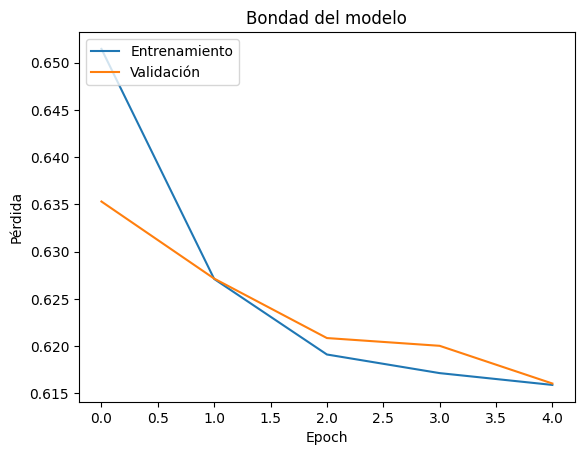

In [34]:
plt.plot(train_output.history["loss"])
plt.plot(train_output.history["val_loss"])
plt.title("Bondad del modelo")
plt.ylabel("Pérdida")
plt.xlabel("Epoch")
plt.legend(["Entrenamiento", "Validación"], loc="upper left")
plt.show()


In [35]:
def nn_recommender(user_id, num=10):
  """
  Deberemos tener en cuenta la codificación antes empleada a la hora de entrenar el modelo
  """
  # Peliculas vistas
  seen_movies = ratings[ratings["user_id"] == user_id]

  # Películas no vistas
  not_seen = movies[~movies["movie_id"].isin(seen_movies["movie_id"].values)]["movie_id"].tolist()
  not_seen = list(set(not_seen).intersection(set(movie2movie_encoded.keys())))
  not_seen = [[movie2movie_encoded.get(x)] for x in not_seen]

  # User
  encoded_id = user2user_encoded.get(user_id)

  # Input data para el modelo
  input_data  = np.hstack(([[encoded_id]] * len(not_seen), not_seen))
  pred_ratings = model.predict(input_data).flatten()

  # Top ratings
  top_rated = pred_ratings.argsort()[-num:][::-1]

  # Decode
  movie_id = [movie_encoded2movie.get(not_seen[x][0]) for x in top_rated]

  return movies[movies["movie_id"].isin(movie_id)]["title"]

In [36]:
nn_recommender(196)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


63                       Shawshank Redemption, The (1994)
97                       Silence of the Lambs, The (1991)
113     Wallace & Gromit: The Best of Aardman Animatio...
123                                      Lone Star (1996)
126                                 Godfather, The (1972)
131                              Wizard of Oz, The (1939)
133                                   Citizen Kane (1941)
135                   Mr. Smith Goes to Washington (1939)
356                One Flew Over the Cuckoo's Nest (1975)
1168                                         Fresh (1994)
Name: title, dtype: object

In [37]:
nn_recommender(5)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


11                            Usual Suspects, The (1995)
126                                Godfather, The (1972)
284                                Secrets & Lies (1996)
301                             L.A. Confidential (1997)
356               One Flew Over the Cuckoo's Nest (1975)
473    Dr. Strangelove or: How I Learned to Stop Worr...
478                                       Vertigo (1958)
479                            North by Northwest (1959)
482                                    Casablanca (1942)
602                                   Rear Window (1954)
Name: title, dtype: object

In [38]:
model.save("recommender_model.keras")